# Rainfall Analysis and Prediction

---

**Author:** [rodoart](https://github.com/rodoart/)<br>
**Date created:** 2023-01-30<br>
**Last modified:** 2023-01-30<br>
**Description:** Making rainfall predictions from one region using Neural Networks and Random Forests


# 3. Weekly predictions


## Path config

In [1]:
PROJECT_SLUG = 'rainfall'
NAME = 'weekly_predictions'
NUMBER = '3.1'

NOTEBOOK_NAME = f'{NUMBER}_{PROJECT_SLUG}-{NAME}.ipynb'


# LOCAL
LOCAL_PATH = '..'

In [2]:
import sys

# It depends on where the library that comes with this package is stored.
sys.path.append(LOCAL_PATH)

In [3]:
from rainfall.utils.paths import make_dir_function

In [4]:
local_dir = make_dir_function(workspace=LOCAL_PATH)

## Libraries

Importing libraries.

In [5]:
from rainfall.utils.paths import make_dir_function
from rainfall.data.make_dataset import StationsDataFrame
from distutils.dir_util import copy_tree

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as skl
import json
import matplotlib.pyplot as plt
import pickle
import keras_tuner as kt

from datetime import datetime, date, timedelta
from sklearn.ensemble import RandomForestRegressor


import IPython

In [6]:
alarm_sound_url = "https://upload.wikimedia.org/wikipedia/commons/4/43/BABS_-_Allgemeiner_Alarm.ogg"

## Load Data

In [8]:
STATE = 'Durango'
MUNICIPALITY = 'Durango'
date_interval = (date(1970,1,1),'')


sdf = StationsDataFrame()
dm = sdf.DailyMedians(STATE, MUNICIPALITY)

pm_weekly = dm.PeriodicMedians('W', date_interval)

pm_weekly.df.head()

,rainfall,evaporation,max_t,min_t,rainy_days,day_of_year
date,,,,,,
1969-12-29,0.75,2.80,16.875,4.125,1,2
1970-01-05,0.00,3.00,19.750,3.750,0,8
1970-01-12,0.00,5.85,19.000,2.500,0,15
1970-01-19,0.00,5.40,21.500,3.000,0,22
1970-01-26,0.00,5.70,22.500,2.500,0,29


## Data preparation

We have a big gap in data before '2011-06-01', then we divide the data set in two before skipping, and then rejoining. 

In [9]:
df_weekly = pm_weekly.skip_with_gaps()
df_weekly.head()

,rainy_days_copy,rainfall_copy,evaporation,max_t,min_t,day_of_year,rainfall,rainy_days
date,,,,,,,,
1970-01-05,1,0.75,2.80,16.875,4.125,2,0.0,0
1970-01-12,0,0.00,3.00,19.750,3.750,8,0.0,0
1970-01-19,0,0.00,5.85,19.000,2.500,15,0.0,0
1970-01-26,0,0.00,5.40,21.500,3.000,22,0.0,0
1970-02-02,0,0.00,5.70,22.500,2.500,29,0.0,0


We create a function for data splitting. 

In [10]:
len(df_weekly)

2504

In [11]:
def limits_to_slices(limits):
  
  limit_list = list(limits)
  
  # Add start.
  limit_list.insert(0,0)

  # First slice.
  slice_list = [slice(limit_list[0], limit_list[0]+limit_list[1])]

  # Next slices
  
  for i in range(2,len(limit_list)):
    current = slice_list[i-2].stop
    slice_list.append(slice(current, current + limit_list[i]))

  return slice_list

In [12]:
def split_data(df, independent_vars, split_dict) -> dict:
  # To slice.
  slices = limits_to_slices(split_dict.values())

  # Definition of dict of data frames with keys: `train`, `test` and `validation.`
  dict_dfs = {}

  for key, sli in zip(split_dict.keys(), slices):
    dict_dfs[key] = df[sli]

    
  # Normalization 
  train_mean = dict_dfs['train'].mean(numeric_only=True)
  train_std = dict_dfs['train'].std(numeric_only=True)

  for key, value in dict_dfs.items():
    if pd.core.dtypes.common.is_numeric_dtype(dict_dfs[key]):
      dict_dfs[key] = (value - train_mean) / train_std


  # Separating dependent variables.
  columns = df.columns.to_list()
  dependet_vars = [column for column in columns if column not in independent_vars]


  # Separating independent variables.
  dict_vars = {}
  for var_name in independent_vars:
    dic_aux_y = {}
    dic_aux_x = {}
    for key, value in dict_dfs.items():
      dic_aux_y[key] = value[var_name]
      dic_aux_x[key] = value[dependet_vars]

    dict_vars[var_name] = {'x':dic_aux_x, 'y': dic_aux_y}

  return dict_vars

In [13]:
# Limit definitions
n_val = round(len(df_weekly)*.2)
n_train = int((len(df_weekly)-n_val)*0.8)
n_test = len(df_weekly) -n_val - n_train

# Dictionary with names and limits.
split_dict = {'train': n_train, 'test': n_test, 'validation': n_val}

train_test_val_dict = split_data(df_weekly, ['rainfall', 'rainy_days'], split_dict)

train_test_val_dict['rainfall']['y']['validation'].tail()

date
2018-11-26    0.0
2018-12-03    0.0
2018-12-10    0.0
2018-12-17    0.0
2018-12-24    0.0
Name: rainfall, dtype: float64

# Functions for evaluation and Plotting

In [14]:
def store_metrics_json(model_name, best_parameters, y_val, y_predict, y_prob=None, type_of_model = 'regression', labels=None):
  
  if type_of_model == 'regression':
    metrics = {'mse':skl.metrics.mean_squared_error,
            'r2_score': skl.metrics.r2_score, 
            'mae': skl.metrics.mean_absolute_error,
            'explained_variance_score': skl.metrics.explained_variance_score}
    file_name = 'model_summaries_rainfall'
  else:
    metrics = {'accuracy_score':skl.metrics.accuracy_score, 
               'crossentropy_loss': lambda y_true, y_pred : \
                  skl.metrics.log_loss(y_true, y_prob,
                                       labels=labels),
               'recall_score':lambda y_true, y_pred : \
                  skl.metrics.recall_score(y_true, y_pred, 
                                           labels=labels,
                                           average='weighted'),
               'f1_score': lambda y_true, y_pred : \
                  skl.metrics.f1_score(y_true, y_pred, average='weighted')
            }
                                         
    file_name = 'model_summaries_rainy_days'



  model_summary = {model_name:{
      'best_parameters': best_parameters
  }}

  for name, function in metrics.items():
    model_summary[model_name][name] = function(y_val, y_predict)
    print(f'{name}: {model_summary[model_name][name]}')


  with open(local_dir('data', 'interim', f'{file_name}.json'), "w") as outfile:
      json.dump(model_summary, outfile)

  return model_summary

In [15]:
def plot_model(y_train, y_test, y_val, y_predict, title, mse, xlabel = None, 
               ylabel = None):
  fig, ax = plt.subplots(figsize=(12, 4))
  ax.plot(y_train.append(y_test))
  ax.plot(y_val , label='truth', linestyle='--',)
  ax.plot(y_val.index, y_predict,  label="prediction (MSE={:0.2f})".format(mse))
  
  ax.set_xlim(datetime(year=2005, month=1, day=1))
  ax.set_ylim(-1,5)

  if xlabel:
    ax.set_xlabel(xlabel)
  
  if ylabel:
    ax.set_ylabel(ylabel)

  ax.legend()
  ax.set_title(title)

In [16]:
def plot_history(history):

  epoch = list(range(1,len(list(history.values())[0])+1))
  
  fig, axs = plt.subplots(2,1, figsize=(12, 8))
  fig.tight_layout(pad=4)

  for ax, metric_name in zip(axs, ['accuracy', 'loss']):
    ax.plot(epoch, history[metric_name], 
            label = f'Train {metric_name}')
    ax.plot(epoch, history[f'val_{metric_name}'], 
            label = f'Test {metric_name}')
    ax.set_title(f'Train and test {metric_name}')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name.capitalize())


# Regression

## Random Forest

In [17]:
def model_rf_load(hp):
  return skl.ensemble.RandomForestRegressor(
      n_estimators = hp.Int('n_estimators', min_value=25, max_value=500, 
                            step=15),
      criterion = 'absolute_error',
      max_depth = hp.Int('max_depth', min_value=150, max_value=1000, step=56),
      min_samples_split = hp.Int('min_samples_split', min_value=2, 
                                 max_value=50, step=10),
      min_samples_leaf = hp.Int('min_samples_leag', min_value=2, 
                                 max_value=500, step=50),
      bootstrap = True  
  )

In [18]:
tuner = kt.tuners.Sklearn(
    oracle = kt.oracles.BayesianOptimization(
        objective= kt.Objective('score', 'max'),
        max_trials=100),
    scoring = skl.metrics.make_scorer(skl.metrics.mean_absolute_error),
    cv = skl.model_selection.TimeSeriesSplit(),
    hypermodel= model_rf_load,
    directory= local_dir('models'),
    project_name='random_forest_regression')

In [19]:
tuner.search(train_test_val_dict['rainfall']['x']['train']\
              .append(train_test_val_dict['rainfall']['x']['test']),
              train_test_val_dict['rainfall']['y']['train']\
              .append(train_test_val_dict['rainfall']['y']['test']).ravel())

Trial 100 Complete [00h 00m 06s]
score: 0.5702060060060061

Best score So Far: 0.5982858858858859
Total elapsed time: 00h 13m 14s
INFO:tensorflow:Oracle triggered exit


In [21]:
pickle.dump(tuner.get_best_models()[0], 
            open(local_dir('models','random_forest.sav'), 'wb'))
tuner.get_best_models()[0]

RandomForestRegressor(criterion='absolute_error', max_depth=990,
                      min_samples_leaf=2, n_estimators=25)

In [22]:
y_predict_rainfall = tuner.get_best_models()[0].predict(
      train_test_val_dict['rainfall']['x']['validation'])

best_parameters = tuner.get_best_models()[0].get_params()
model_name = "random_forests"
model_summary = store_metrics_json(model_name, 
                                   best_parameters, 
                                   train_test_val_dict['rainfall']['y']['validation'], 
                                   y_predict_rainfall)


mse: 2.293766840319361
r2_score: 0.1773402401541666
mae: 0.6692075848303394
explained_variance_score: 0.18736560021620086


C:\Users\rodoa\AppData\Local\Temp\ipykernel_25712\2200843803.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax.plot(y_train.append(y_test))


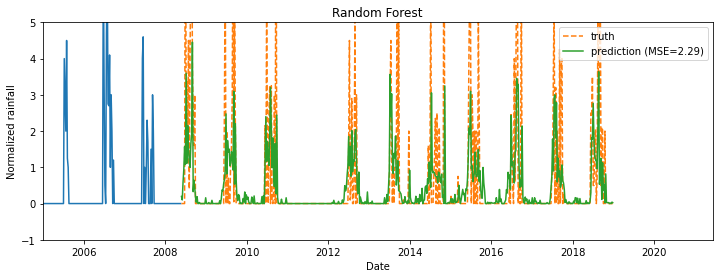

In [23]:
plot_model(train_test_val_dict['rainfall']['y']['train'], 
           train_test_val_dict['rainfall']['y']['test'], 
           train_test_val_dict['rainfall']['y']['validation'], 
           y_predict_rainfall, 
           'Random Forest', 
           model_summary[model_name]['mse'],
           xlabel = 'Date',
           ylabel = 'Normalized rainfall')

## Neural Network

In [24]:
def model_nn_load(hp):
  model = tf.keras.models.Sequential()

  regularizer_type = hp.Choice('regularizer_type', values = ['None', 'l2', 'l1_l2'])
  
  if regularizer_type == 'l1_l2':
    regularizer = tf.keras.regularizers.l1_l2(1e-5, 1e-5)
  elif regularizer_type == 'l2':
    regularizer = tf.keras.regularizers.l2(1e-5)
  else:
    regularizer = None 
  
  
  model.add(tf.keras.layers.Dense(
      16, input_dim=6, kernel_regularizer = regularizer, 
      activation='relu'
      ))
  model.add(tf.keras.layers.Dropout(0.2))


  model.add(tf.keras.layers.Dense(
      hp.Choice('inner_neurons', values = [64, 128, 256, 512, 1024]), 
      kernel_regularizer = regularizer, 
      activation='relu'
      ))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))

  output_neurons = hp.Choice('output_neurons', values = [0, 64, 128, 256, 512])
  if output_neurons!=0:
    model.add(tf.keras.layers.Dense(
        output_neurons, 
        kernel_regularizer = regularizer, 
        activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
  
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss='mse', 
                optimizer= tf.keras.optimizers.Adam(learning_rate=
                    hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
                ), 
                metrics=['accuracy'])
  return model

In [25]:
tuner = kt.RandomSearch(
    hypermodel=model_nn_load,
    objective=kt.Objective('val_loss','min'),
    max_trials=600,
    directory=local_dir('models'),
    project_name='neural_network_regression',
    overwrite = True
)

In [26]:
tuner.search(
    x = train_test_val_dict['rainfall']['x']['train'],
    y = train_test_val_dict['rainfall']['y']['train'], 
    validation_data=(train_test_val_dict['rainfall']['x']['test'], 
                     train_test_val_dict['rainfall']['y']['test']),
    epochs = 60,
    verbose = 4,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=6,
      verbose=0,
      mode="auto"
    )]
  )

Trial 191 Complete [00h 00m 13s]
val_loss: 1.443543791770935

Best val_loss So Far: 1.371145486831665
Total elapsed time: 00h 34m 56s
INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.get_best_models()[0].save(local_dir('models','neural_network_rainfall.h5'))
tuner.get_best_hyperparameters()[0].values

{'regularizer_type': 'l2',
 'inner_neurons': 512,
 'output_neurons': 256,
 'learning_rate': 0.01}

In [29]:
y_predict_rainfall = tuner.get_best_models()[0].predict(
      train_test_val_dict['rainfall']['x']['validation'])

y_predict_rainfall[y_predict_rainfall <=0] = 0

best_parameters = tuner.get_best_models()[0].get_config()
model_name = "neural_network"
model_summary = store_metrics_json(model_name, 
                                   best_parameters, 
                                   train_test_val_dict['rainfall']['y']['validation'], 
                                   y_predict_rainfall)

16/16 [==============================] - 0s 4ms/step
mse: 2.1030618059401482
r2_score: 0.245736624226905
mae: 0.7269908419150316
explained_variance_score: 0.24589090538051905


C:\Users\rodoa\AppData\Local\Temp\ipykernel_25712\2200843803.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax.plot(y_train.append(y_test))


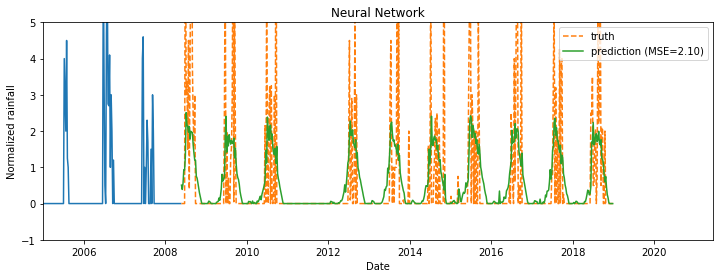

In [30]:
plot_model(train_test_val_dict['rainfall']['y']['train'], 
           train_test_val_dict['rainfall']['y']['test'], 
           train_test_val_dict['rainfall']['y']['validation'], 
           y_predict_rainfall, 
           'Neural Network', 
           model_summary[model_name]['mse'],
           xlabel = 'Date',
           ylabel = 'Normalized rainfall')

## Recursive Neural Networks



In [31]:
def generator_for_lstm_layer(x, y, 
                             x_test, y_test, 
                             x_val, n_input, 
                             b_size, n_features=None, is_class = False):
  if n_features is None:
      n_features= x.shape[1]
    
  # scale so that all the X data will range from 0 to 1
  xscaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1)) 
  xscaler.fit(x)

  scaled_x = xscaler.transform(x)
  scaled_x_test = xscaler.transform(x_test)

  scaled_x_test

  # Convert to data frame.
  y = y.to_frame()
  y_test = y_test.to_frame()
  

  # Data between 0 and 1
  if is_class:
    yscaler = skl.preprocessing.FunctionTransformer(func=np.array)
  else:
    yscaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
  
  
  yscaler.fit(y)
  scaled_y = yscaler.transform(y)
  scaled_y_test = yscaler.transform(y_test)


  # remove the second dimention from y so the shape changes from (n,1) to (n,)

  scaled_y = scaled_y.reshape(-1) 
  scaled_y_test = scaled_y_test.reshape(-1)

  # Generators
  generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_x, scaled_y, length=n_input, batch_size=b_size)
  generator_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_x_test, scaled_y_test, length=n_input, batch_size=b_size)

  scaled_x_val = xscaler.transform(x_val)
  generator_val =  tf.keras.preprocessing.sequence.TimeseriesGenerator(
      scaled_x_val, np.zeros(len(x_val)), length=n_input, batch_size=b_size)

  return generator, generator_test, generator_val, yscaler


In [32]:
n_input = 4 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 5 # how many predictors/Xs/features we have to predict y
b_size = int(365/7) # Number of timeseries samples in each batch


generator_train_rainfall, generator_test, generator_val, yscaler =\
  generator_for_lstm_layer(train_test_val_dict['rainfall']['x']['train'].drop('rainfall_copy', axis=1),
                           train_test_val_dict['rainfall']['y']['train'], 
                           train_test_val_dict['rainfall']['x']['test'].drop('rainfall_copy', axis=1), 
                           train_test_val_dict['rainfall']['y']['test'],
                           train_test_val_dict['rainfall']['x']['validation'].drop('rainfall_copy', axis=1), 
                           n_input=n_input, b_size=b_size)
  

In [34]:
def model_rnn_load(hp):
  model = tf.keras.models.Sequential()

  regularizer_type = hp.Choice('regularizer_type', values = ['None', 'l2', 'l1_l2'])
  
  if regularizer_type == 'l1_l2':
    regularizer = tf.keras.regularizers.l1_l2(1e-5, 1e-5)
  elif regularizer_type == 'l2':
    regularizer = tf.keras.regularizers.l2(1e-5)
  else:
    regularizer = None 


  model.add(tf.keras.layers.LSTM(
      hp.Choice('neurons_layer_1', values = [64, 128, 256, 512, 1024, 2048]), 
      activation='relu', 
      input_shape=(n_input, n_features), 
      kernel_regularizer = regularizer,
      return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))

  neurons_layer_2 = hp.Choice('neurons_layer_2', values = [0, 64, 128])
  if neurons_layer_2 != 0:
    model.add(tf.keras.layers.LSTM(
        neurons_layer_2,
        kernel_regularizer = regularizer,
        activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

  neurons_layer_3 = hp.Choice('neurons_layer_3', values = [0, 256, 512])
  
  if neurons_layer_3!=0:
    model.add(tf.keras.layers.Dense(
        neurons_layer_3, 
        kernel_regularizer = regularizer, 
        activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
  
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss='mse', 
                optimizer= tf.keras.optimizers.Adam(learning_rate=
                    hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
                ), 
                metrics=['accuracy'])
  return model


In [35]:
tuner = kt.RandomSearch(
    hypermodel=model_rnn_load,
    objective=kt.Objective('val_loss','min'),
    max_trials=600,
    directory=local_dir('models'),
    project_name='recurent_network_regression',
    overwrite = True
)

In [36]:
tuner.search(
    generator_train_rainfall, 
    validation_data=generator_test,
    epochs = 100,
    verbose = 4,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=6,
      verbose=0,
      mode="auto"
    )]
  )

Trial 368 Complete [00h 00m 48s]
val_loss: 0.010054925456643105

Best val_loss So Far: 0.00952896662056446
Total elapsed time: 1d 02h 14m 07s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.get_best_models()[0].save(local_dir('models','recurrent_neural_network_rainfall.h5'))
tuner.get_best_hyperparameters()[0].values

{'regularizer_type': 'None',
 'neurons_layer_1': 512,
 'neurons_layer_2': 128,
 'neurons_layer_3': 0,
 'learning_rate': 0.0001}

In [38]:
y_predict_rainfall_scaled = tuner.get_best_models()[0].predict(generator_val)
y_predict_rainfall = yscaler.inverse_transform(y_predict_rainfall_scaled)
y_predict_rainfall = y_predict_rainfall.ravel()

y_val_rainfall = train_test_val_dict['rainfall']['y']['validation'][n_input:]

10/10 [==============================] - 2s 24ms/step


In [39]:
model_name = "recurrent_neural_network"
best_parameters=tuner.get_best_hyperparameters()[0].values

model_summary = store_metrics_json(model_name, best_parameters, y_val_rainfall, y_predict_rainfall)

mse: 2.2273569459996354
r2_score: 0.20654154149617598
mae: 0.7298459776795246
explained_variance_score: 0.2210390993583603


C:\Users\rodoa\AppData\Local\Temp\ipykernel_25712\2200843803.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax.plot(y_train.append(y_test))


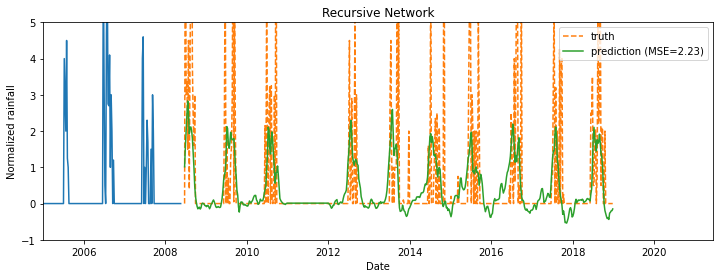

In [41]:
plot_model(train_test_val_dict['rainfall']['y']['train'], 
           train_test_val_dict['rainfall']['y']['test'], 
           y_val_rainfall, 
           y_predict_rainfall, 
           'Recursive Network', 
           model_summary[model_name]['mse'],
           xlabel = 'Date',
           ylabel = 'Normalized rainfall')

# Classification

## Random Forest

In [42]:
def model_rf_load(hp):
  return skl.ensemble.RandomForestClassifier(
      n_estimators = hp.Int('n_estimators', min_value=25, max_value=500, 
                            step=15),
      criterion = 'entropy',
      max_depth = hp.Int('max_depth', min_value=150, max_value=1000, step=56),
      min_samples_split = hp.Int('min_samples_split', min_value=2, 
                                 max_value=50, step=10),
      min_samples_leaf = hp.Int('min_samples_leag', min_value=2, 
                                 max_value=500, step=50),
      bootstrap = True  
  )

In [43]:
tuner_rf = kt.tuners.Sklearn(
    oracle = kt.oracles.BayesianOptimization(
        objective= kt.Objective('score', 'max'),
        max_trials=100),
    scoring = skl.metrics.make_scorer(skl.metrics.accuracy_score),
    cv = skl.model_selection.TimeSeriesSplit(),
    hypermodel= model_rf_load,
    directory= local_dir('models'),
    project_name='random_forest_classification')

In [44]:
tuner_rf.search(train_test_val_dict['rainy_days']['x']['train']\
              .append(train_test_val_dict['rainy_days']['x']['test']),
              train_test_val_dict['rainy_days']['y']['train']\
              .append(train_test_val_dict['rainy_days']['y']['test']).astype(int).ravel())

Trial 100 Complete [00h 00m 04s]
score: 0.6780780780780781

Best score So Far: 0.6840840840840842
Total elapsed time: 00h 14m 41s
INFO:tensorflow:Oracle triggered exit


In [45]:
pickle.dump(tuner_rf.get_best_models()[0], 
            open(local_dir('models', 'random_forest_classifier.sav'), 'wb'))
tuner_rf.get_best_models()[0]

RandomForestClassifier(criterion='entropy', max_depth=710, min_samples_leaf=2,
                       min_samples_split=32, n_estimators=475)

In [46]:
y_predict_rainy_days = tuner_rf.get_best_models()[0].predict(
    train_test_val_dict['rainy_days']['x']['validation'])
y_proba_rainy_days = tuner_rf.get_best_models()[0].predict_proba(
    train_test_val_dict['rainy_days']['x']['validation'])
y_val_rainy_days =  train_test_val_dict['rainy_days']['y']['validation']\
    .astype(int).ravel()

y_labels = list(set(y_predict_rainy_days).union(set(y_val_rainy_days)))

best_parameters = tuner_rf.get_best_models()[0].get_params()
model_name = "random_forests_classifier"

model_summary = store_metrics_json(model_name, 
                                   best_parameters, 
                                   y_val_rainy_days, 
                                   y_predict_rainy_days,
                                   y_prob=y_proba_rainy_days,
                                   labels=y_labels,
                                   type_of_model = 'classifier')

accuracy_score: 0.6187624750499002
crossentropy_loss: 1.053156298516355
recall_score: 0.6187624750499002
f1_score: 0.5198308913218779


## Neural Network

In [47]:
def model_nn_load_classifier(hp):
  model = tf.keras.models.Sequential()

  regularizer_type = hp.Choice('regularizer_type', values = ['None', 'l2', 'l1_l2'])
  
  if regularizer_type == 'l1_l2':
    regularizer = tf.keras.regularizers.l1_l2(1e-5, 1e-5)
  elif regularizer_type == 'l2':
    regularizer = tf.keras.regularizers.l2(1e-5)
  else:
    regularizer = None 
  
  
  model.add(tf.keras.layers.Dense(
      16, input_dim=6, kernel_regularizer = regularizer, 
      activation='relu'
      ))
  model.add(tf.keras.layers.Dropout(0.2))


  model.add(tf.keras.layers.Dense(
      hp.Choice('inner_neurons', values = [64, 128, 256, 512, 1024]), 
      kernel_regularizer = regularizer, 
      activation='relu'
      ))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))

  output_neurons = hp.Choice('output_neurons', values = [0, 64, 128, 256, 512])
  if output_neurons!=0:
    model.add(tf.keras.layers.Dense(
        output_neurons, 
        kernel_regularizer = regularizer, 
        activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
  
  model.add(tf.keras.layers.Dense(8, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer= tf.keras.optimizers.Adam(learning_rate=
                    hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
                ), 
                metrics=['accuracy'])
  return model

In [48]:
tuner_nn = kt.RandomSearch(
    hypermodel=model_nn_load_classifier,
    objective=kt.Objective('accuracy','max'),
    max_trials=600,
    directory=local_dir('models'),
    project_name='neural_network_classification',
    overwrite = True
)

In [49]:
tuner_nn.search(
    x = train_test_val_dict['rainy_days']['x']['train'],
    y = train_test_val_dict['rainy_days']['y']['train'].astype(int), 
    validation_data=(train_test_val_dict['rainy_days']['x']['test'], 
                     train_test_val_dict['rainy_days']['y']['test'].astype(int)),
    epochs = 60,
    verbose = 4,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(
      monitor="accuracy",
      patience=6,
      verbose=0,
      mode="auto"
    )]
  )

Trial 187 Complete [00h 00m 10s]
accuracy: 0.6691635251045227

Best accuracy So Far: 0.6916354298591614
Total elapsed time: 01h 05m 42s
INFO:tensorflow:Oracle triggered exit


In [50]:
tuner_nn.get_best_models()[0].save(local_dir('models','neural_network_rainy_days.h5'))
tuner_nn.get_best_hyperparameters()[0].values

{'regularizer_type': 'l2',
 'inner_neurons': 512,
 'output_neurons': 128,
 'learning_rate': 0.01}

In [54]:
train_test_val_dict['rainy_days']['y']['train'].astype(int)

date
1970-01-05    0
1970-01-12    0
1970-01-19    0
1970-01-26    0
1970-02-02    0
             ..
2000-08-14    1
2000-08-21    2
2000-08-28    0
2000-09-04    0
2000-09-11    3
Name: rainy_days, Length: 1602, dtype: int32

In [64]:
t_m = tuner_nn.get_best_models()[0]
y_predict_rainy_days = t_m.predict(train_test_val_dict['rainy_days']['x']['validation'])

16/16 [==============================] - 0s 4ms/step


In [65]:
skl.metrics.log_loss(y_true = train_test_val_dict['rainy_days']['y']['validation'].astype(int).ravel(),
                     y_pred = y_predict_rainy_days,
                     labels=list(range(0,8)))

1.2776036609443808

In [66]:
y_proba_rainy_days = tuner_nn.get_best_models()[0].predict(
      train_test_val_dict['rainy_days']['x']['validation'])
y_predict_rainy_days = [np.argmax(y_proba_rainy_days[i,:]) 
                        for i in range(y_proba_rainy_days.shape[0])]


best_parameters = tuner_nn.get_best_models()[0].get_config()
model_name = "neural_network_classifier"
model_summary = store_metrics_json(model_name, 
                                   best_parameters, 
                                   train_test_val_dict['rainy_days']['y']['validation'].astype(int).ravel(), 
                                   y_predict_rainy_days,
                                   y_prob=y_proba_rainy_days, 
                                   type_of_model = 'classifier')

16/16 [==============================] - 0s 4ms/step
accuracy_score: 0.6087824351297405
crossentropy_loss: 1.2776036609443808
recall_score: 0.6087824351297405
f1_score: 0.4680588571600517


## Recurrent Neural Network

In [67]:
n_input = 4 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 5 # how many predictors/Xs/features we have to predict y
b_size = int(365/7) # Number of timeseries samples in each batch
num_classes = 8


generator_train_rainy_days, generator_test, generator_val, yscaler =\
  generator_for_lstm_layer(train_test_val_dict['rainy_days']['x']['train'].drop('rainy_days_copy', axis=1),
                           train_test_val_dict['rainy_days']['y']['train'].astype(int), 
                           train_test_val_dict['rainy_days']['x']['test'].drop('rainy_days_copy', axis=1), 
                           train_test_val_dict['rainy_days']['y']['test'].astype(int),
                           train_test_val_dict['rainy_days']['x']['validation'].drop('rainy_days_copy', axis=1), 
                           n_input=n_input, b_size=b_size, is_class = False)
  

In [68]:
def model_rnn_load_classifier(hp):

  # Chosing regularizer
  regularizer_type = hp.Choice('regularizer_type', values = ['None', 'l2', 'l1_l2'])
  
  if regularizer_type == 'l1_l2':
    regularizer = tf.keras.regularizers.l1_l2(1e-5, 1e-5)
  elif regularizer_type == 'l2':
    regularizer = tf.keras.regularizers.l2(1e-5)
  else:
    regularizer = None 

  

  input_layer = tf.keras.layers.Input(shape=(n_input, n_features))

  lstm1 = tf.keras.layers.LSTM(
    hp.Choice('neurons_layer_1', values = [64, 128, 256, 512, 1024, 2048]), 
    kernel_regularizer = regularizer,
    return_sequences=True
  )(input_layer)
  
  lstm1 = tf.keras.layers.BatchNormalization()(lstm1)
  lstm1 = tf.keras.layers.ReLU()(lstm1)

  neurons_layer_2 = hp.Choice('neurons_layer_2', values = [0, 64, 128])

  if neurons_layer_2!=0:
    lstm2 = tf.keras.layers.LSTM(
      neurons_layer_2,  
      kernel_regularizer = regularizer
    )(lstm1)
    
    lstm2 = tf.keras.layers.BatchNormalization()(lstm2)
    lstm2 = tf.keras.layers.ReLU()(lstm2)
  else:
    lstm2 = lstm1

    #neurons_layer_3 = hp.Choice('neurons_layer_3', values = [0, 64, 128])

  #if neurons_layer_3!=0:
   # lstm3 = tf.keras.layers.Dense(
    #  neurons_layer_3,  
     # kernel_regularizer = regularizer
    #)(lstm2)
    
    #lstm3 = tf.keras.layers.BatchNormalization()(lstm3)
    #lstm3 = tf.keras.layers.ReLU()(lstm3)
  #else:
  lstm3 = lstm2

  output_layer = tf.keras.layers.Dense(1)(lstm3)
  
  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
  
  model.compile(loss='mse', 
                optimizer= tf.keras.optimizers.Adam(learning_rate=
                    hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
                ), 
                metrics=['accuracy'])
  return model


In [69]:
tuner_rnn = kt.RandomSearch(
    hypermodel=model_rnn_load_classifier,
    objective=kt.Objective('val_loss','min'),
    max_trials=600,
    directory=local_dir('models'),
    project_name='recurrent_neural_network_classification',
    overwrite = True
)

In [70]:
tuner_rnn.search(
    generator_train_rainy_days, 
    validation_data=generator_test,
    epochs = 100,
    verbose = 4,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=6,
      verbose=0,
      mode="auto"
    )]
  )

Trial 64 Complete [00h 00m 22s]
val_loss: 0.0663006380200386

Best val_loss So Far: 0.028544265776872635
Total elapsed time: 02h 05m 23s

Search: Running Trial #65

Value             |Best Value So Far |Hyperparameter
None              |None              |regularizer_type
2048              |512               |neurons_layer_1
64                |64                |neurons_layer_2
0.01              |0.01              |learning_rate

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100


In [ ]:
tuner_rnn.get_best_models()[0].save(local_dir('models','recurrent_neural_network_classifier.h5'))
tuner_rnn.get_best_hyperparameters()[0].values

{'learning_rate': 0.0001,
 'neurons_layer_1': 1024,
 'neurons_layer_2': 128,
 'regularizer_type': 'None'}

In [ ]:
y_predict_rainy_days_scaled = tuner_rnn.get_best_models()[1].predict(generator_val)
y_predict_rainy_days = yscaler.inverse_transform(y_predict_rainy_days_scaled)
y_predict_rainy_days = y_predict_rainy_days.ravel()

y_val_rainy_days = train_test_val_dict['rainy_days']['y']['validation'][n_input:]
y_predict_rainy_days

IndexError: ignored

In [ ]:
y_predict_rainy_days[y_predict_rainy_days>=0]

array([], dtype=float32)

In [ ]:
y_proba_rainy_days = tuner_rnn.get_best_models()[0].predict(
      train_test_val_dict['rainy_days']['x']['validation'])
y_predict_rainy_days = [np.argmax(y_proba_rainy_days[i,:]) 
                        for i in range(y_proba_rainy_days.shape

best_parameters = tuner_rnn.get_best_models()[0].get_config()
model_name = "recurrent_neural_network_classifier"
model_summary = store_metrics_json(model_name, 
                                   best_parameters, 
                                   train_test_val_dict['rainy_days']['y']['validation'].astype(int).ravel(), 
                                   y_predict_rainy_days,
                                   y_prob=y_proba_rainy_days, 
                                   type_of_model = 'classifier')